## author: Keer Mei
- github: kmei92
- email: keer.mei18@imperial.ac.uk

# Setup

In [1]:
# importing the necessary modules
import sys
sys.path.append("..")
from PDESystem import *
from PDESubsystem import *
from pdeforms import *

%load_ext autoreload
%autoreload 2

In [2]:
# a PDESystem child class called PDESolver. Note, the setup_constants function and setup_bcs are declared
# and overloaded here and the PDESystem's functions are not used. This is designed for clarity
class pde_solver(PDESystem):
    def __init__(self, comp, mesh, parameters):
        PDESystem.__init__(self, comp, mesh, parameters)

    def setup_bcs(self):
        x, y = fd.SpatialCoordinate(self.mesh)

        bcu = [fd.DirichletBC(self.V['u'], fd.Constant((0,0)), (1, 4)), # top-bottom and cylinder
            fd.DirichletBC(self.V['u'], ((4.0*1.5*y*(0.41 - y) / 0.41**2) ,0), 2)] # inflow
        bcp = [fd.DirichletBC(self.V['p'], fd.Constant(0), 3)]  # outflow

        self.bc['u'][0] = [bcu, None, None, None,'fixed']
        self.bc['p'] = [[bcp, None, None, None, 'fixed']]
        
    def setup_constants(self):
        x, y = fd.SpatialCoordinate(self.mesh)
        self.constants = {
            'k' : fd.Constant(self.prm['dt']),
            'n' : fd.FacetNormal(self.mesh),
            'f' : fd.Constant((0.0, 0.0)),
            'nu' : fd.Constant(0.001),
            'eps' : fd.Constant(0.01),
            'K' : fd.Constant(10.0),
            'f_1' : fd.conditional(pow(x-0.1, 2)+pow(y-0.1,2)<0.05*0.05, 0.1, 0),
            'f_2' : fd.conditional(pow(x-0.1, 2)+pow(y-0.3,2)<0.05*0.05, 0.1, 0),
            'f_3' : fd.Constant(0.0)
        }

# Solve

In [6]:
# update the parameters
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'c' : fd.MixedFunctionSpace},
'degree': {'u': 2 },
'order' : {'c' : 3},
'ksp_type': {'u': 'gmres', 'p': 'gmres', 'c':'gmres'},
'subsystem_class' : {'up' : navier_stokes, 'c':reactions},
'precond': {'u': 'sor', 'p' : 'sor', 'c':'sor'},
'dt' : 0.005,
 'T' : 1.0 }                         
)

# load the mesh
mesh = fd.Mesh("../../meshes/cylinder1.msh") 
# declare a new pde_solver object with a velocity and pressure variable
solver = pde_solver([['u', 'p']], mesh, solver_parameters)
# add a concentration system to the pde_solver object
solver.add_subsystem('c', solver_parameters)
# set up constants
solver.setup_constants()
# define the pdesystems and variable sequence
solver.define(['u', 'p', 'u'], 'up', navier_stokes)
solver.define(['c'], 'c', reactions)
# setup boundary conditions
solver.setup_bcs()
# solve
solver.solve()

0 1.0 0.005
[[<firedrake.bcs.DirichletBC object at 0x7f74ebcc3cf8>, <firedrake.bcs.DirichletBC object at 0x7f74ebcc3e48>], [<firedrake.bcs.DirichletBC object at 0x7f74ebcfae80>], [], []]
["fd.solve(self.a[0] == self.L[0], self.form_args['u_'], bcs=boundaries[0], solver_parameters={'ksp_type': self.prm['ksp_type']['u'], 'pc_type': self.prm['precond']['u']})", "fd.solve(self.a[1] == self.L[1], self.form_args['p_'], bcs=boundaries[1], solver_parameters={'ksp_type': self.prm['ksp_type']['p'], 'pc_type': self.prm['precond']['p']})", "fd.solve(self.a[2] == self.L[2], self.form_args['u_'], bcs=boundaries[2], solver_parameters={'ksp_type': self.prm['ksp_type']['u'], 'pc_type': self.prm['precond']['u']})", "fd.solve(self.a[3] == self.L[3], self.form_args['c_'], bcs=boundaries[3])"]
["fd.solve(self.forms[0] == 0, self.form_args['u_'], bcs=boundaries[0], solver_parameters={'ksp_type': self.prm['ksp_type']['u'], 'pc_type': self.prm['precond']['u']})", "fd.solve(self.forms[1] == 0, self.form_args['

In [6]:
import time

# update the parameters
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'c' : fd.MixedFunctionSpace},
'degree': {'u': 2 },
'order' : {'c' : 3},
'ksp_type': {'u': 'gmres', 'p': 'gmres', 'c':'gmres'},
'subsystem_class' : {'up' : navier_stokes, 'c':reactions},
'precond': {'u': 'sor', 'p' : 'sor', 'c':'sor'},
'dt' : 0.0005,
 'T' : 1.0 }                         
)


solve_time = []
for i in range(1, 6):
    # load the mesh
    mesh = fd.Mesh("../../meshes/cylinder%d.msh" % i) 
    # declare a new pde_solver object with a velocity and pressure variable
    solver = pde_solver([['u', 'p']], mesh, solver_parameters)
    # add a concentration system to the pde_solver object
    solver.add_subsystem('c', solver_parameters)
    # set up constants
    solver.setup_constants()
    # define the pdesystems and variable sequence
    solver.define(['u', 'p', 'u'], 'up')
    solver.define(['c'], 'c')
    # setup boundary conditions
    solver.setup_bcs()
    # solve
    start = time.clock()
    solver.solve()
    end = time.clock()
    print('total time: ', end-start)
    solve_time.append(end-start)

time = 1.000
total time:  269.418922
time = 1.000
total time:  371.305249
time = 1.000
total time:  390.178774
time = 1.000
total time:  405.47173999999995
time = 1.000
total time:  562.9829359999999


# Plotting

(-0.11000000000000006,
 2.310000000000001,
 -0.020500000000000004,
 0.43050000000000005)

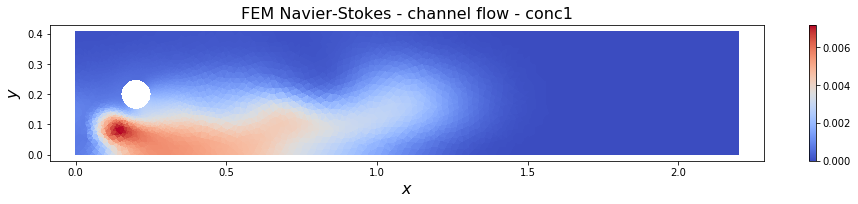

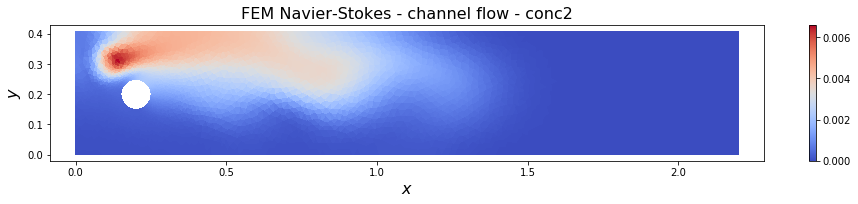

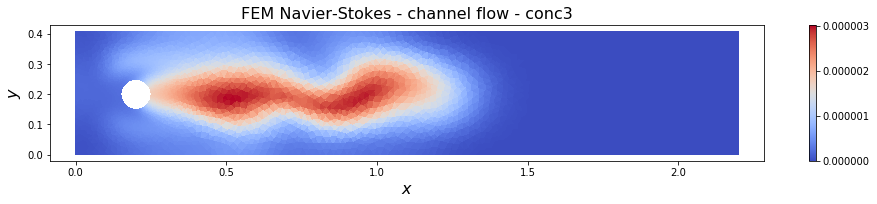

In [7]:
# since C is a mixedfunctionspace variable, use firedrake's split function to retrieve each
# subcomponent
c1, c2, c3 = solver.form_args['c_'].split()

fig4 = plt.figure(figsize=(16, 2.5))
ax4 = fig4.add_subplot(111)
ax4.set_xlabel('$x$', fontsize=16)
ax4.set_ylabel('$y$', fontsize=16)
ax4.set_title('FEM Navier-Stokes - channel flow - conc1', fontsize=16)
fd.plot(c1,axes=ax4)
ax4.axis('equal')

fig5 = plt.figure(figsize=(16, 2.5))
ax5 = fig5.add_subplot(111)
ax5.set_xlabel('$x$', fontsize=16)
ax5.set_ylabel('$y$', fontsize=16)
ax5.set_title('FEM Navier-Stokes - channel flow - conc2', fontsize=16)
fd.plot(c2,axes=ax5)
ax5.axis('equal')

fig6 = plt.figure(figsize=(16, 2.5))
ax6 = fig6.add_subplot(111)
ax6.set_xlabel('$x$', fontsize=16)
ax6.set_ylabel('$y$', fontsize=16)
ax6.set_title('FEM Navier-Stokes - channel flow - conc3', fontsize=16)
fd.plot(c3,axes=ax6)
ax6.axis('equal')

## Uncoupled Reactions

In [8]:
# update the parameters, here since the new PDESystem is a series of uncoupled reaction equations,
# we have replaced the variable 'c' with 'c1', 'c2', and 'c3' to represent each subcomponent
solver_parameters = recursive_update(solver_parameters,
{
'space': {'u': fd.VectorFunctionSpace, 'c1': fd.FunctionSpace, 'c2' :fd.FunctionSpace, 'c3':fd.FunctionSpace},
'degree': {'u': 2},
'ksp_type': {'u': 'gmres', 'p': 'gmres', 'c1': 'gmres','c2': 'gmres','c3': 'gmres'},
'subsystem_class' : {'up' : navier_stokes, 'c1c2c3' : reactions_uncoupled}, #also a new system is declared
'precond': {'u': 'sor', 'p' : 'sor', 'c1': 'sor','c2': 'sor','c3': 'sor'},
'dt' : 0.0005,
 'T' : 1.0 }                         
)

uncoupled_solve_time = []
total_vertices = []
for i in range(1, 6):
    # load the mesh
    mesh = fd.Mesh("../../meshes/cylinder%d.msh" % i) 
    # declare a new pde_solver object with a velocity and pressure variable
    solver = pde_solver([['u', 'p']], mesh, solver_parameters)
    # add a concentration system to the pde_solver object
    solver.add_subsystem(['c1', 'c2', 'c3'], solver_parameters)
    # set up constants
    solver.setup_constants()
    # define the pdesystems
    solver.define(['u', 'p', 'u'], 'up')
    solver.define(['c1', 'c2', 'c3'], 'c1c2c3')
    # setup boundary conditions
    solver.setup_bcs()
     # solve
    start = time.clock()
    solver.solve()
    end = time.clock()
    print('total time: ', end-start)
    uncoupled_solve_time.append(end-start)
    total_vertices.append(mesh.num_vertices())

time = 1.000
total time:  149.8065160000001
time = 1.000
total time:  197.0166650000001
time = 1.000
total time:  230.44544600000017
time = 1.000
total time:  263.1010140000003
time = 1.000
total time:  368.2452909999997


(-0.11000000000000006,
 2.310000000000001,
 -0.020500000000000004,
 0.43050000000000005)

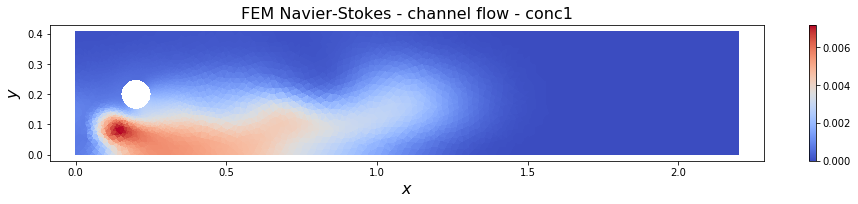

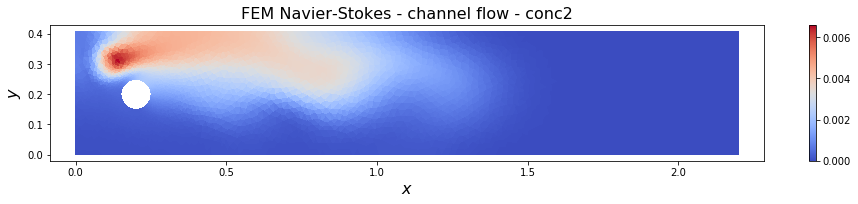

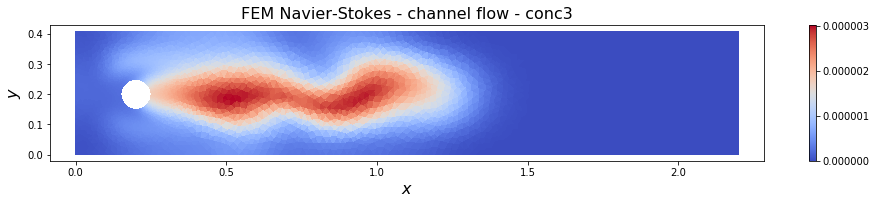

In [9]:
# no longer need to split the variable 'c' since there are three separate variables to represent
# each chemical species
fig4 = plt.figure(figsize=(16, 2.5))
ax4 = fig4.add_subplot(111)
ax4.set_xlabel('$x$', fontsize=16)
ax4.set_ylabel('$y$', fontsize=16)
ax4.set_title('FEM Navier-Stokes - channel flow - conc1', fontsize=16)
fd.plot(solver.form_args['c1_'],axes=ax4)
ax4.axis('equal')

fig5 = plt.figure(figsize=(16, 2.5))
ax5 = fig5.add_subplot(111)
ax5.set_xlabel('$x$', fontsize=16)
ax5.set_ylabel('$y$', fontsize=16)
ax5.set_title('FEM Navier-Stokes - channel flow - conc2', fontsize=16)
fd.plot(solver.form_args['c2_'],axes=ax5)
ax5.axis('equal')

fig6 = plt.figure(figsize=(16, 2.5))
ax6 = fig6.add_subplot(111)
ax6.set_xlabel('$x$', fontsize=16)
ax6.set_ylabel('$y$', fontsize=16)
ax6.set_title('FEM Navier-Stokes - channel flow - conc3', fontsize=16)
fd.plot(solver.form_args['c3_'],axes=ax6)
ax6.axis('equal')

## Plotting coupled vs uncoupled reaction solve times

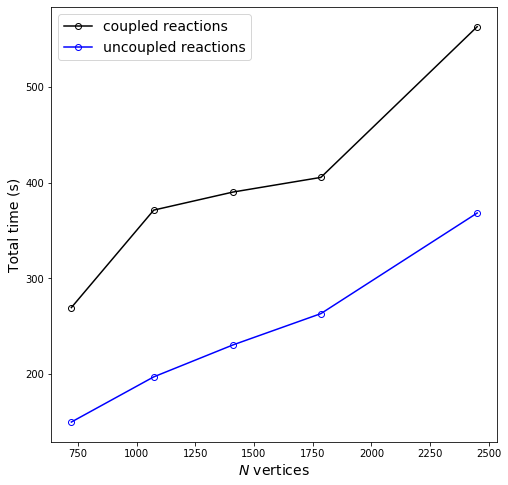

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))
# plot error map

ax1.plot(total_vertices, solve_time, 'o-', label='coupled reactions', color='k', markerfacecolor='None')
ax1.plot(total_vertices, uncoupled_solve_time, 'o-', label='uncoupled reactions', color='b', markerfacecolor='None')

ax1.set_xlabel('$N$ vertices', fontsize=14)
ax1.set_ylabel('Total time (s)', fontsize=14)
# ax1.set_title('Error convergence graph vs. $\Delta t$', fontsize=14)
ax1.legend(loc='best', fontsize=14)